Попробуем делать это следующим образом:
<ol> План работы
<li> Регрессор по тем же параметрам, что использовал в третьей неделе.
<li> Предсказания на 6 часов вперёд по SARIMAX
<li> Решающий лес
</ol>

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import datetime
from sklearn import preprocessing, linear_model, model_selection
from sklearn.tree import DecisionTreeRegressor as DTR
import statsmodels.api as sm
from itertools import product
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import make_scorer 


%matplotlib inline

/home/frodos/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
def processDataFrame(inpDf, Kw = 7, Ka = 2):
    """
    Обрабатываем сразу весь dateFrame и добавляем признаки, общие для всех рядов
    тренд, гармоники, категориальные перемнные
    для дат, дней недели, etc)

    Parameters:
    Kw number of weeks harmonics
    Ka number of annual harmonics
    """   
    inpDf = inpDf.assign(linear = (inpDf.index - datetime.datetime(2014,1,1,0,0,0))/np.timedelta64(1, 'h'))
    
    # час — эти признаки можно пробовать брать и категориальными
    # и непрерывными, можно даже и так, и так

    # добавляем гармонические фичи
    for ind in range(1,Kw+1):
        inpDf['weekCos'+str(ind)]= np.cos(np.pi*inpDf.linear*ind/168)
        inpDf['weekSin'+str(ind)]= np.sin(np.pi*inpDf.linear*ind/168)
     
    for ind in range(1,Ka+1):
        inpDf['yearCos'+str(ind)]= np.cos(2*np.pi*inpDf.linear*ind/8766)        
        inpDf['yearSin'+str(ind)]= np.sin(2*np.pi*inpDf.linear*ind/8766)

    # добавляем числовое и категориальные свойства для дней недели
    inpDf = inpDf.assign(dayOfWeek = inpDf.index.dayofweek)
    lbDays = preprocessing.LabelBinarizer()
    lbDays.fit(list(np.arange(6)))
    DoW = pd.DataFrame(lbDays.transform(inpDf.index.dayofweek),columns = ['dayOfWeek_'+str(x) for x in np.arange(6)],
                       index = inpDf.index)      
    inpDf = inpDf.merge(DoW,left_index=True,right_index=True)

    # добавляем dummy variables для месяца
    inpDf = inpDf.assign(month = inpDf.index.month)
    lbMonths = preprocessing.LabelBinarizer()
    lbMonths.fit(list(np.arange(12)))
    Months = pd.DataFrame(lbMonths.transform(inpDf.index.month),columns = ['month_'+str(x) for x in np.arange(1,13)],
                          index = inpDf.index)      
    inpDf = inpDf.merge(Months,left_index=True,right_index=True);

    # добавляем год (вещественный)
    inpDf = inpDf.assign(year = inpDf.index.year)

    # добавляем день месяца (вещественный)
    inpDf = inpDf.assign(day = inpDf.index.day)

    # добавляем час (вещественный и категориальный)
    inpDf = inpDf.assign(hour = inpDf.index.hour)
    lbHours = preprocessing.LabelBinarizer()
    lbHours.fit(list(np.arange(24)))
    Hours = pd.DataFrame(lbHours.transform(inpDf.index.hour),columns = ['hour_'+str(x) for x in np.arange(24)],
                       index = inpDf.index)      
    inpDf = inpDf.merge(Hours,left_index=True,right_index=True)
    
    return inpDf

In [5]:
# define time frames
startTrain = '2014-01-01 00:00:00'
endTrain   = '2016-04-30 23:00:00'

startValidation = '2016-05-01 00:00:00'
endValidation   = '2016-05-31 23:00:00'

startTest = '2016-06-01 00:00:00'
endTest   = '2016-06-30 23:00:00'

In [6]:
# id нужных регионов
regsDf = pd.read_csv('../crowdRegs.csv',names=['id','regId']);  

# времянные ряды для этих регионов
df = pd.read_pickle('../loadData/crowdRegs3.pcl')
regNames = regsDf.regId.values.astype('str')
df.columns = regNames

In [7]:
# общая обработка данных
tmp = df.columns.values
df = processDataFrame(df,Kw = 7, Ka = 4)
commonFeatures =  list(set(df.columns)-set(tmp))

In [8]:
# convert to flat structure
df2 = pd.DataFrame()
for regName in regNames:
    tDf = df.loc[:,regName.split() + commonFeatures].rename(columns={regName:'y'})
    tDf = tDf.assign(region = regName)
    df2 = pd.concat([df2,tDf])

In [9]:
df2 = df2.assign(regressor = 0)

In [10]:
# делает регрессию на признаки
for regName in regNames:
    subSet = df2.query('region == @regName')
    linReg = linear_model.Ridge(alpha=100)
    linReg.fit(subSet.loc[startTrain:endValidation,:].drop(['y','regressor'],axis=1),
               subSet.loc[startTrain:endValidation,'y'])
    prediction = linReg.predict(subSet.drop(['y','regressor'],axis=1))
    prediction[prediction<0]=0
    df2.loc[df2.region == regName,'regressor'] = prediction

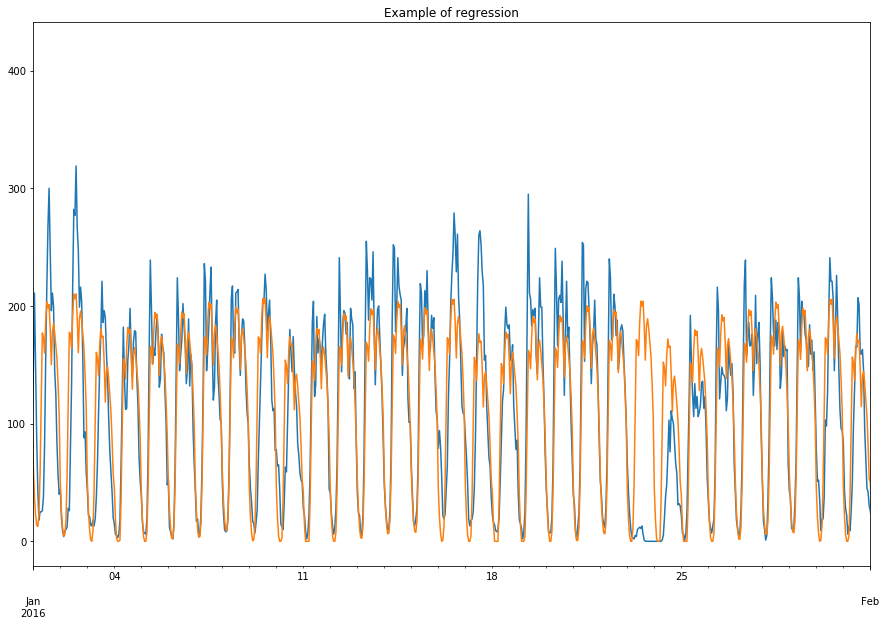

In [11]:
testSet = df2.query("region == '1076'")
plt.figure(figsize=[15,10])
testSet.y.plot()
testSet.regressor.plot()
plt.xlim(['01-2016','02-2016'])
plt.title('Example of regression')

Посчитаем ошибку регрессора

In [12]:
MAE(df2.regressor,df2.y)

36.558103383110847

На лидерборде скор равен 29.47504

In [14]:
df3 = df2.loc['23:00:00 05-31-2016':'23:00:00 6-30-2016',['regressor','region']]
df3 = df3.assign(y1 = df3.regressor.shift(-1)).assign(y2 = df3.regressor.shift(-2)).assign(y3 = df3.regressor.shift(-3))
df3 = df3.assign(y4 = df3.regressor.shift(-4)).assign(y5 = df3.regressor.shift(-5)).assign(y6 = df3.regressor.shift(-6))

In [15]:
df3.head()

,regressor,region,y1,y2,y3,y4,y5,y6
2016-05-31 23:00:00,71.540724,1075,45.745937,30.932136,21.165573,16.281813,15.886044,18.246113
2016-06-01 00:00:00,45.745937,1075,30.932136,21.165573,16.281813,15.886044,18.246113,28.519581
2016-06-01 01:00:00,30.932136,1075,21.165573,16.281813,15.886044,18.246113,28.519581,44.865702
2016-06-01 02:00:00,21.165573,1075,16.281813,15.886044,18.246113,28.519581,44.865702,69.466790
2016-06-01 03:00:00,16.281813,1075,15.886044,18.246113,28.519581,44.865702,69.466790,69.365258


In [18]:
saveFile(df3,'w5-r2.csv')

Попробуем улучшить качество регрессора

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [30]:
poly = PolynomialFeatures(degree=2, include_bias=False)
linReg = linear_model.Ridge(alpha=100)
ppl = Pipeline([('poly', poly), ('Ridge', linReg)])

# делает регрессию на признаки
for regName in regNames:
    subSet = df2.query('region == @regName')
    
    ppl.fit(subSet.loc[startTrain:endValidation,:].drop(['y','regressor'],axis=1),
               subSet.loc[startTrain:endValidation,'y'])
    prediction = ppl.predict(subSet.drop(['y','regressor'],axis=1))
    prediction[prediction<0]=0
    df2.loc[df2.region == regName,'regressor'] = prediction
    
print 'MAE is', MAE(df2.regressor,df2.y)

MAE is 20.3853242062


Скор на лидерборде 47.52875 
 Ничего абсолютно не понимаю. Как так может быть???

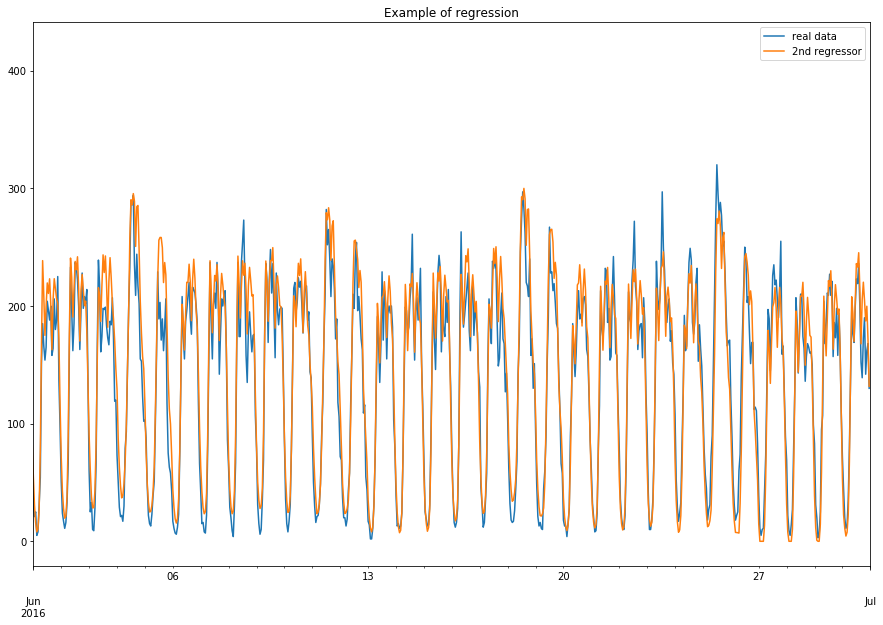

In [31]:
testSet2 = df2.query("region == '1076'")
plt.figure(figsize=[15,10])
testSet2.y.plot()
testSet2.regressor.plot()
plt.xlim(['06-2016','07-2016'])
plt.title('Example of regression')
plt.legend(['real data','2nd regressor'])

In [32]:
df3 = df2.loc['23:00:00 05-31-2016':'23:00:00 6-30-2016',['regressor','region']]

Попробую засабмитить результат на kaggle и сравнить скор.

In [39]:
df3 = df3.assign(y1 = df3.regressor.shift(-1)).assign(y2 = df3.regressor.shift(-2)).assign(y3 = df3.regressor.shift(-3))
df3 = df3.assign(y4 = df3.regressor.shift(-4)).assign(y5 = df3.regressor.shift(-5)).assign(y6 = df3.regressor.shift(-6))
df3.head()

,regressor,region,y1,y2,y3,y4,y5,y6
2016-05-31 23:00:00,60.962714,1075,35.980620,14.731042,4.230435,0.000000,0.000000,2.194965
2016-06-01 00:00:00,35.980620,1075,14.731042,4.230435,0.000000,0.000000,2.194965,15.524949
2016-06-01 01:00:00,14.731042,1075,4.230435,0.000000,0.000000,2.194965,15.524949,45.030544
2016-06-01 02:00:00,4.230435,1075,0.000000,0.000000,2.194965,15.524949,45.030544,79.372081
2016-06-01 03:00:00,0.000000,1075,0.000000,2.194965,15.524949,45.030544,79.372081,62.702518


In [46]:
saveFile(df3,'w5-r3.csv')

In [45]:
fName = 'w5.csv'

def saveFile(df_inp,fName = 'w5.csv'):
    f = open(fName,'w')
    f.writelines('id,y\n')
    
    
    
    df = df_inp.reset_index()
    df.rename(columns={'index':'date'},inplace=True)

    for ind, row in df.iterrows():
        historyStart = row.date

        if historyStart > datetime.datetime(2016,6,30,17):
            continue

        s0 = str(row.region)+'_'+ str(datetime.datetime.strftime(historyStart, "%Y-%m-%d"))+ '_'+ str(historyStart.hour)

        s1 = s0 +'_1,'+str(rnd(row.get('y1'))) + '\n'
        f.writelines(s1)

        s2 = s0 +'_2,'+str(rnd(row.get('y2'))) + '\n'
        f.writelines(s2)

        s3 = s0 +'_3,'+str(rnd(row.get('y3'))) + '\n'
        f.writelines(s3)

        s4 = s0 +'_4,'+str(rnd(row.get('y4'))) + '\n'
        f.writelines(s4)

        s5 = s0 +'_5,'+str(rnd(row.get('y5'))) + '\n'
        f.writelines(s5)

        s6 = s0 +'_6,'+str(rnd(row.get('y6'))) + '\n'
        f.writelines(s6)

    f.close()    
    
def rnd(x):
    return int(np.round(x))

In [68]:
# теперь надо затащить SARIMAX модель

In [47]:
a = list()

In [48]:
for regName in regNames:

SyntaxError: unexpected EOF while parsing (<ipython-input-48-5448a8f6539a>, line 1)

In [51]:
a.append(1)

In [52]:
a

[1, 1, 1]

In [55]:
a.remove(1)

In [56]:
a

[1]